# Experiment: Bollinger Bands Scaling Strategy (BBSS)


In [1]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import talib
from tqdm import tqdm


def load(file_):
    try:
        _df = pd.read_csv(file_, parse_dates=True)
        _df.datetime = pd.to_datetime(_df.datetime)
        _df['date'] = _df.datetime.dt.date
        _df.set_index('datetime', inplace=True)
        return _df
    except Exception as e:
        return pd.DataFrame()


def mark_events(data, ref_frame=5):
    data = data.copy()
    data['sell'] = (
        data['close'] == data['close'].shift(-ref_frame).rolling(2 * ref_frame).max()).astype(int).replace(0, None)
    data['buy'] = (
        data['close'] == data['close'].shift(-ref_frame).rolling(2 * ref_frame).min()).astype(int).replace(0, None)
    data['hold'] = data.apply(lambda row: int(
        not (row['sell'] or row['buy'])), axis=1)
    return data


file_df = pd.DataFrame([
    {
        'stock_code': file_.split('/')[-2],
        'path': file_,
    } for file_ in glob('/workspace/nifty/NIFTY/2023*.csv')
    if 'options_history' not in file_ and 'OPTIONS' not in file_ and 'CALL' not in file_ and 'PUT' not in file_
])

df_map = {}


for stock, group in tqdm(file_df.groupby('stock_code')):
    df_map[stock] = pd.concat(
        list(
            map(
                load,
                sorted(group.path.tolist())
            )
        )
    ).sort_index()

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


In [2]:
from backtesting import Strategy
from typing import Tuple
from backtester import simulate

Signal = Tuple[bool, bool, bool]


def mark_action(data, positions, trades, closed_trades):
    buy, close_pos, sell = False, False, False
    if data.strategy_buy and (not positions.size or positions.is_short):
        buy = True
        close_pos = True
    elif data.strategy_sell and (not positions.size or positions.is_long):
        sell = True
        close_pos = True
    return buy, close_pos, sell


class BBStrategy(Strategy):
    signal = None
    SL = 5
    TP = 10

    def _is_trading_window(self):
        if (
            self.data.index[-1].hour == 15 and
            self.data.index[-1].minute > 15
        ) or (
            self.data.index[-1].hour == 9 and
            self.data.index[-1].minute < 30
        ):
            return False
        return True

    def __init__(self, broker, data, params):
        super().__init__(broker, data, params)
        self.signal = params['signal']

    def init(self):
        self._open = self.data.Open
        self._high = self.data.High
        self._low = self.data.Low
        self._close = self.data.Close

    def next(self):
        if not self._is_trading_window():
            self.position.close()
            return

        buy, close, sell = self.signal(
            self.data,
            self.position,
            self.trades,
            self.closed_trades
        )

        if close:
            self.position.close()

        if buy:
            self.buy(
                size=1,
                # sl=self.data.Low - self.SL,
            )

        if sell:
            self.sell(
                size=1,
                # sl=self.data.High + self.SL
            )

In [3]:
import numpy as np

BUY_QUANTILE = .5
SELL_QUANTILE = .20
DEVIATION = 2
TIMEPERIOD = 20
REF_FRAME = 12


def scale_by_bb(
        series: pd.Series,
        deviation: int = 2,
        timeperiod: int = 20
):
    upper, _, lower = talib.BBANDS(
        series,
        timeperiod=timeperiod,
        nbdevup=deviation,
        nbdevdn=deviation
    )
    return (series - lower) / (upper - lower)


def evaluate_metrics(
        stock_code,
        df,
        deviation=DEVIATION,
        timeperiod=TIMEPERIOD,
        ref_frame=REF_FRAME
):
    dfs = []
    initial_cash = df.high.max() * 5
    for _, group in tqdm(df.groupby('date'), desc=stock_code):
        group['scaled_close'] = scale_by_bb(group.close, deviation, timeperiod)
        dfs.append(
            mark_events(
                group,
                ref_frame=ref_frame
            )
        )

    df = pd.concat(dfs)
    poi_buy = (df.scaled_close * df.buy).dropna()
    poi_sell = (df.scaled_close * df.sell).dropna()
    buy_threshold = poi_buy.quantile(BUY_QUANTILE)
    sell_threshold = poi_sell.quantile(SELL_QUANTILE)

    # Exit Strategy
    df['strategy_buy'] = (df.scaled_close >= buy_threshold) & (
        df.scaled_close.shift(1) < buy_threshold)
    df['strategy_sell'] = (df.scaled_close <= sell_threshold) & (
        df.scaled_close.shift(1) > sell_threshold)

    # Entry Strategy
    # df['strategy_buy'] = (df.scaled_close <= buy_threshold) & (
    #     df.scaled_close.shift(1) > buy_threshold)
    # df['strategy_sell'] = (df.scaled_close >= sell_threshold) & (
    #     df.scaled_close.shift(1) < sell_threshold)

    df['strategy_buy'] = df['strategy_buy'].astype(int).replace(0, None)
    df['strategy_sell'] = df['strategy_sell'].astype(int).replace(0, None)

    stats = simulate(
        df.rename(
            {
                'open': 'Open',
                'high': 'High',
                'low': 'Low',
                'close': 'Close',
            },
            axis=1
        ),
        cash=initial_cash,
        strategy=mark_action,
        backtest_class=BBStrategy,
    )

    # stats._trades.to_csv(f'./simulations/{stock_code}_trades.csv', index=False)

    return {
        'stock_code': stock_code,
        'initial_cash': initial_cash,
        'buy_threshold': buy_threshold,
        'sell_threshold': sell_threshold,
        'Return [%]': stats['Return [%]'],
        'Equity Final [$]': stats['Equity Final [$]'],
        'Avg. Drawdown [%]': stats['Avg. Drawdown [%]'],
        '# Trades': stats['# Trades'],
        'Win Rate [%]': stats['Win Rate [%]'],
        'Avg. Trade Duration': stats['Avg. Trade Duration'],
        'Expectancy [%]': stats['Expectancy [%]'],
    }

In [4]:
ndf = df_map['NIFTY'].copy()
ndf.drop(columns=['only_date', 'exchange_code',
         'stock_code', 'volume'], inplace=True)
ndf['hour'] = ndf.reset_index().datetime.dt.hour.values
ndf['day_of_week'] = ndf.reset_index().datetime.dt.dayofweek.values
dates = ndf.date.unique()[-500:]

dfs = []
initial_cash = ndf.high.max() * 5
for _, group in tqdm(ndf.groupby('date')):
    group['scaled_close'] = scale_by_bb(group.close, 2, 6)
    start_index = group.index[-1].replace(hour=9, minute=30)
    end_index = group.index[-1].replace(hour=15, minute=15)
    group = group[start_index:end_index].copy()

    dfs.append(
        mark_events(
            group,
            ref_frame=4
        )
    )

ndf = pd.concat(dfs)
ndf

  0%|          | 0/242 [00:00<?, ?it/s]

100%|██████████| 242/242 [00:00<00:00, 262.67it/s]


,open,high,low,close,date,hour,day_of_week,scaled_close,sell,buy,hold
datetime,,,,,,,,,,,
2023-01-02 09:30:00,18101.90,18111.55,18094.25,18094.35,2023-01-02,9,0,0.182213,None,None,1.0
2023-01-02 09:31:00,18093.40,18103.55,18086.50,18103.20,2023-01-02,9,0,0.448954,None,None,1.0
2023-01-02 09:32:00,18103.25,18103.25,18091.70,18096.25,2023-01-02,9,0,0.237267,None,None,1.0
2023-01-02 09:33:00,18096.20,18117.70,18089.95,18112.45,2023-01-02,9,0,0.948226,None,None,1.0
2023-01-02 09:34:00,18112.75,18128.70,18107.10,18122.85,2023-01-02,9,0,0.950973,None,None,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29 15:11:00,21732.60,21736.00,21730.25,21731.75,2023-12-29,15,4,0.166548,None,None,1.0
2023-12-29 15:12:00,21731.20,21731.85,21718.95,21718.95,2023-12-29,15,4,-0.019801,None,None,1.0
2023-12-29 15:13:00,21718.80,21729.55,21716.30,21728.95,2023-12-29,15,4,0.430657,None,None,1.0


In [5]:
# ndf['poi_buy'] = (ndf.scaled_close * ndf.buy).dropna()
# ndf['poi_sell'] = (ndf.scaled_close * ndf.sell).dropna()

# ndf['poi_hold'] = ndf.scaled_close * (
#     ~(
#         ndf['poi_buy'].astype(bool).fillna(False) &
#         ndf['poi_sell'].fillna(False).astype(bool)
#     )
# ).astype(int)


# fig, (ax, hax) = plt.subplots(2, 1, figsize=(20, 3), sharex=True)
# ndf['poi_buy'].plot.box(vert=False, ax=ax, color='g')
# ndf['poi_sell'].plot.box(vert=False, ax=ax.twinx(), color='r')
# ndf['poi_hold'].plot.box(vert=False, ax=hax, color='b')
# buy_threshold = ndf['poi_buy'].quantile(BUY_QUANTILE)
# sell_threshold = ndf['poi_sell'].quantile(SELL_QUANTILE)

# # df['poi_hold'].plot.box(vert=False, ax=ax.twinx().twinx(), color='r')
# ax.axvline(buy_threshold, color='g')
# hax.axvline(buy_threshold, color='g')
# ax.axvline(sell_threshold, color='r')
# hax.axvline(sell_threshold, color='r')

# ndf

In [6]:

# BUY_QUANTILE = .5
# SELL_QUANTILE = .25
# for day, group in ndf.groupby(['hour']):
#     fig, (ax, hax) = plt.subplots(2, 1, figsize=(20, 5), sharex=True)
#     group['poi_buy'].plot.box(vert=False, ax=ax, color='g')
#     group['poi_sell'].plot.box(vert=False, ax=ax.twinx(), color='r')
#     group['poi_hold'].plot.box(vert=False, ax=hax, color='b')
#     ax.set_title(day)
#     buy_threshold = group['poi_buy'].quantile(BUY_QUANTILE)
#     sell_threshold = group['poi_sell'].quantile(SELL_QUANTILE)

#     # df['poi_hold'].plot.box(vert=False, ax=ax.twinx().twinx(), color='r')
#     ax.axvline(buy_threshold, color='g')
#     hax.axvline(buy_threshold, color='g')
#     ax.axvline(sell_threshold, color='r')
#     hax.axvline(sell_threshold, color='r')
#     plt.show()
#     plt.close()

#     # print(day, group[['poi_buy', 'poi_sell', 'poi_hold']
#     #                  ].quantile([.05, .5, .95]))
#     # print()

In [7]:
from tqdm import trange

metrics = []

configs = []
for frame in range(4, 15, 2):
    for period in range(4, 25, 4):
        configs.append((frame, period))


for frame, period in tqdm(configs):
    metric = evaluate_metrics(
        'NIFTY',
        ndf[ndf.date.isin(dates)],
        deviation=DEVIATION,
        timeperiod=period,
        ref_frame=frame
    )
    metric.update({
        'frame': frame,
        'period': period
    })
    metrics.append(
        metric
    )

metrics_df = pd.DataFrame(metrics)
metrics_df['Win Rate [%]'] = metrics_df['Win Rate [%]'].round()
metrics_df['Return [%]'] = metrics_df['Return [%]'].round()
metrics_df.to_csv('./nifty_metrics.csv', index=False)
metrics_df.sort_values(
    ['Win Rate [%]', 'Equity Final [$]'], ascending=[False, False])

100%|██████████| 36/36 [02:42<00:00,  4.51s/it]


,stock_code,initial_cash,buy_threshold,sell_threshold,Return [%],Equity Final [$],Avg. Drawdown [%],# Trades,Win Rate [%],Avg. Trade Duration,Expectancy [%],frame,period
31,NIFTY,108921.25,0.078006,0.836772,3.0,111879.40,-0.025801,5466,64.0,0 days 01:36:00,0.002785,14,8
25,NIFTY,108921.25,0.078885,0.836428,3.0,111742.50,-0.026606,5478,64.0,0 days 01:35:00,0.002645,12,8
19,NIFTY,108921.25,0.079998,0.835781,2.0,111557.70,-0.027196,5488,64.0,0 days 01:35:00,0.002474,10,8
13,NIFTY,108921.25,0.084419,0.833004,2.0,111383.50,-0.027248,5586,64.0,0 days 01:34:00,0.002292,8,8
20,NIFTY,108921.25,0.061696,0.840356,0.0,109129.50,-0.045507,3900,64.0,0 days 02:14:00,0.000215,10,12
26,NIFTY,108921.25,0.045086,0.860628,0.0,108997.45,-0.036985,3658,64.0,0 days 02:23:00,0.000181,12,12
32,NIFTY,108921.25,0.042948,0.862973,-0.0,108768.45,-0.038485,3618,64.0,0 days 02:24:00,-0.000155,14,12
34,NIFTY,108921.25,0.032948,0.844865,-1.0,108066.65,-0.075327,2391,64.0,0 days 03:38:00,-0.001817,14,20
28,NIFTY,108921.25,0.049661,0.816259,-1.0,107958.25,-0.062054,2547,64.0,0 days 03:25:00,-0.001908,12,20
21,NIFTY,108921.25,0.064118,0.811705,-1.0,107862.05,-0.095353,3190,64.0,0 days 02:44:00,-0.001903,10,16


NIFTY: 100%|██████████| 242/242 [00:00<00:00, 263.69it/s]


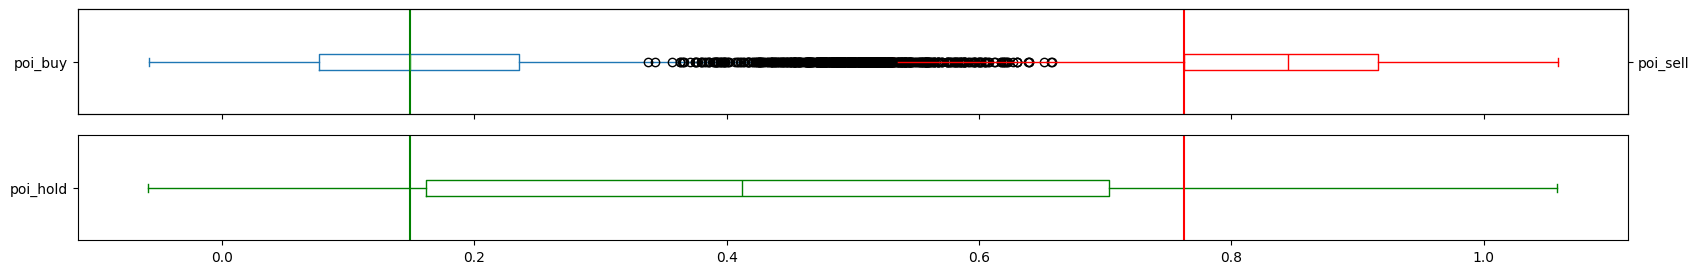

In [8]:
df, stock_code = df_map['NIFTY'], 'NIFTY'

dfs = []
initial_cash = df.high.max() * 5
for _, group in tqdm(df.groupby('date'), desc=stock_code):
    group['scaled_close'] = scale_by_bb(group.close, 2, 6)
    start_index = group.index[-1].replace(hour=9, minute=30)
    end_index = group.index[-1].replace(hour=15, minute=15)
    group = group[start_index:end_index].copy()

    dfs.append(
        mark_events(
            group,
            ref_frame=4
        )
    )

df = pd.concat(dfs)
df.drop(columns=['only_date'], inplace=True)
df.date = pd.to_datetime(df.date)
df['day_of_week'] = df.date.dt.day_of_week

df['poi_buy'] = (df.scaled_close * df.buy).dropna()
df['poi_sell'] = (df.scaled_close * df.sell).dropna()

df['poi_hold'] = df.scaled_close * (~(df['poi_buy'].astype(bool).fillna(
    False) & df['poi_sell'].fillna(False).astype(bool))).astype(int)
buy_threshold = df['poi_buy'].quantile(BUY_QUANTILE)
sell_threshold = df['poi_sell'].quantile(SELL_QUANTILE)

BUY_QUANTILE = .5
SELL_QUANTILE = .25

fig, (ax, hax) = plt.subplots(2, 1, figsize=(20, 3), sharex=True)
df['poi_buy'].plot.box(vert=False, ax=ax)
df['poi_sell'].plot.box(vert=False, ax=ax.twinx(), color='r')
df['poi_hold'].plot.box(vert=False, ax=hax, color='g')

buy_threshold = df['poi_buy'].quantile(BUY_QUANTILE)
sell_threshold = df['poi_sell'].quantile(SELL_QUANTILE)

# df['poi_hold'].plot.box(vert=False, ax=ax.twinx().twinx(), color='r')
ax.axvline(buy_threshold, color='g')
hax.axvline(buy_threshold, color='g')
ax.axvline(sell_threshold, color='r')
hax.axvline(sell_threshold, color='r')

In [9]:
metrics = []

for stock_code in tqdm(df_map):
    try:
        metric = evaluate_metrics(
            stock_code,
            df_map[stock_code],
            deviation=DEVIATION,
            timeperiod=6,
            ref_frame=4
        )
        metrics.append(
            metric
        )
        pd.DataFrame(metrics).to_csv('metrics_6_4.csv', index=False)
    except Exception as e:
        print(e)
        pass

100%|██████████| 1/1 [00:05<00:00,  5.64s/it]


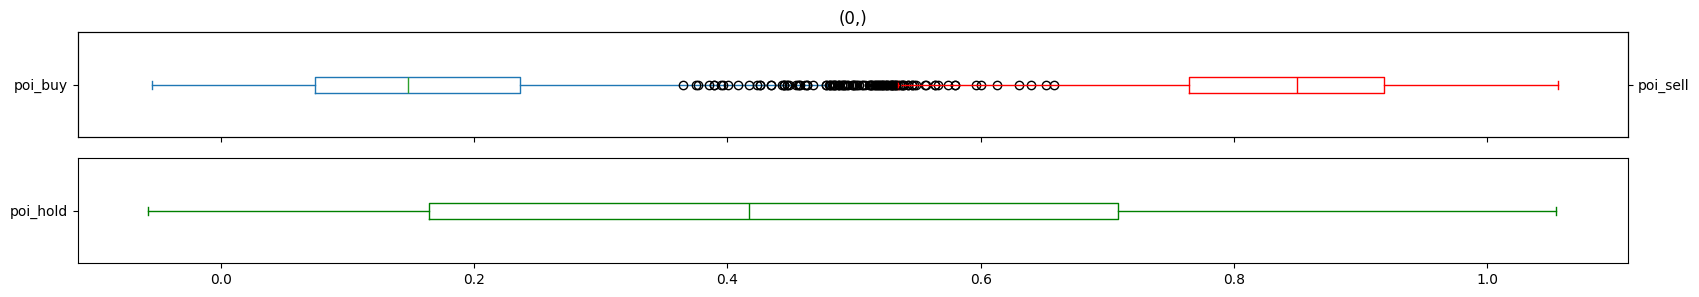

(0,)        poi_buy  poi_sell  poi_hold
0.05 -0.006672  0.556924  0.000000
0.50  0.147533  0.849725  0.417351
0.95  0.461697  0.999729  0.925730



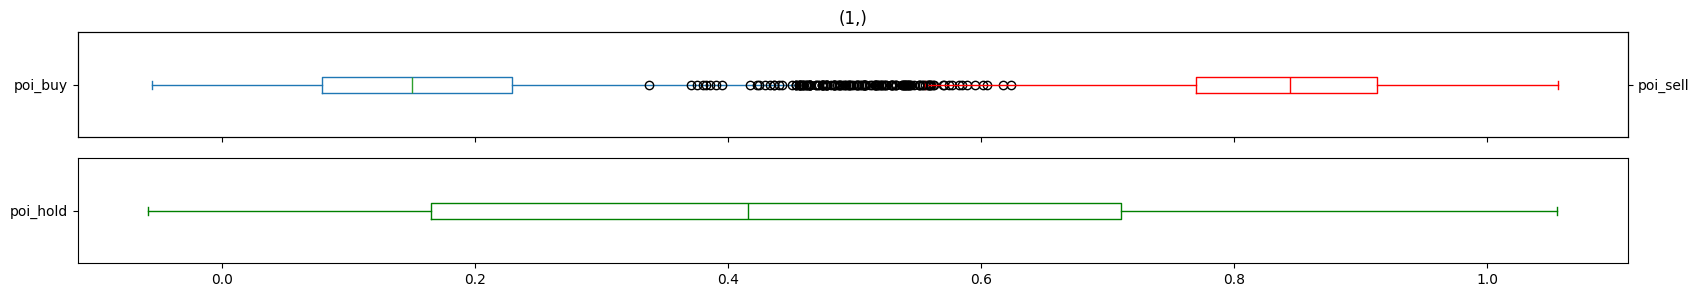

(1,)        poi_buy  poi_sell  poi_hold
0.05 -0.004286  0.542995  0.000000
0.50  0.149833  0.844223  0.415636
0.95  0.471392  0.998663  0.926464



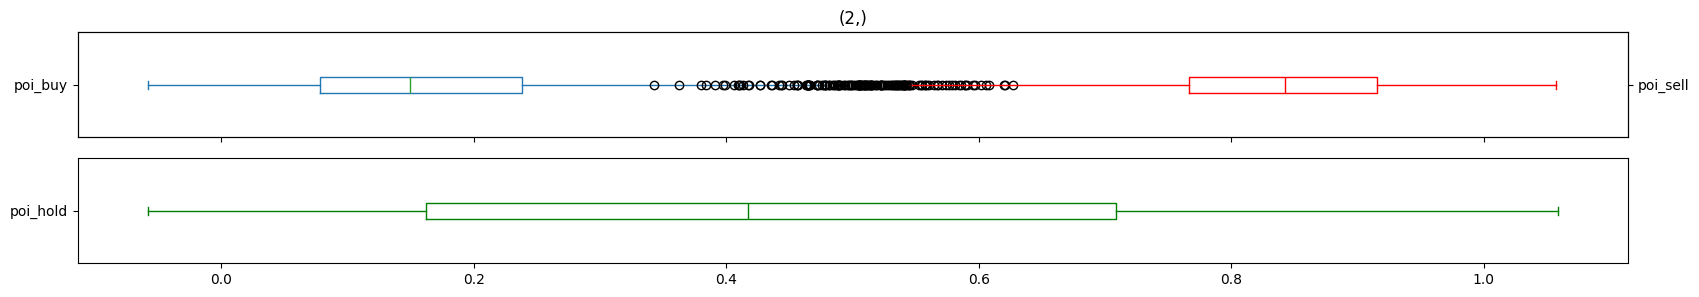

(2,)        poi_buy  poi_sell  poi_hold
0.05 -0.007566  0.527172  0.000000
0.50  0.149962   0.84273  0.416935
0.95  0.469262  1.003449  0.926306



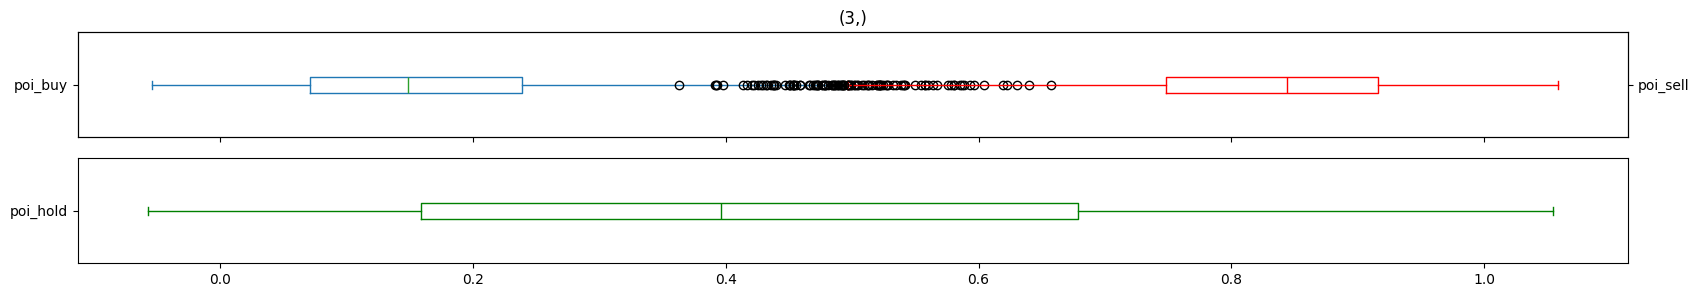

(3,)        poi_buy  poi_sell  poi_hold
0.05  -0.00654  0.520332  0.000000
0.50   0.14835  0.844088  0.396486
0.95  0.468364  0.999859  0.923746



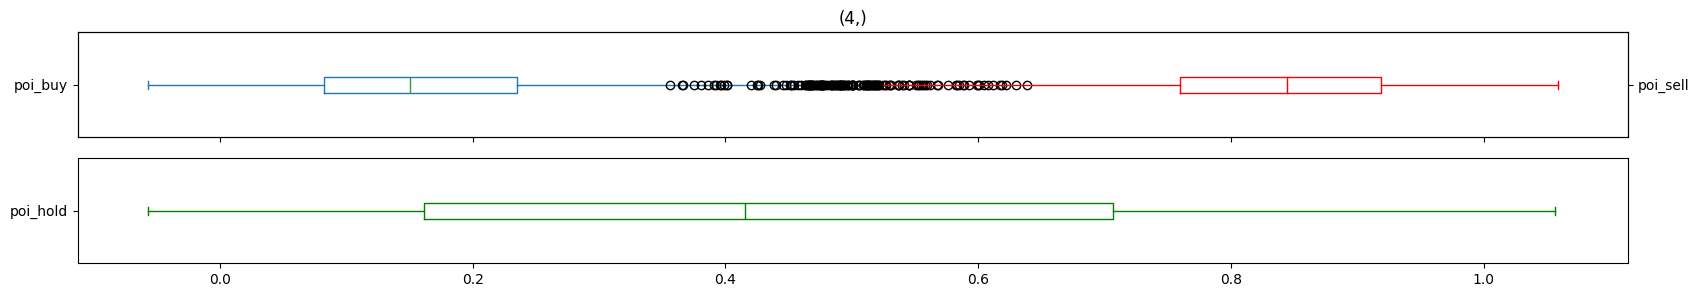

(4,)        poi_buy  poi_sell  poi_hold
0.05 -0.003577  0.531755  0.000000
0.50  0.150691  0.843988  0.415679
0.95  0.480302  1.012422  0.929572



In [10]:

for day, group in df.groupby(['day_of_week']):
    fig, (ax, hax) = plt.subplots(2, 1, figsize=(20, 3), sharex=True)
    group['poi_buy'].plot.box(vert=False, ax=ax)
    group['poi_sell'].plot.box(vert=False, ax=ax.twinx(), color='r')
    group['poi_hold'].plot.box(vert=False, ax=hax, color='g')
    ax.set_title(day)
    plt.show()
    plt.close()

    print(day, group[['poi_buy', 'poi_sell', 'poi_hold']
                     ].quantile([.05, .5, .95]))
    print()